# Homework 3 

In [ ]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [ ]:
plt.figure()

def desert_or_forest(path: str):
    # Загрузка изображения с указанного пути
    image = cv2.imread(path)
    # Преобразование изображения из цветового пространства BGR в RGB
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

    # Преобразование изображения в оттенки серого
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Вычисление гистограммы для градаций серого
    hist_image = cv2.calcHist([image_gray.ravel()], [0], None, [256], [0, 256])

    # Определение типа изображения: лес или пустыня
    # Сравнивается сумма значений гистограммы в двух диапазонах яркости
    result = 'forest' if sum(hist_image[30:100]) > sum(hist_image[100:200]) else 'desert'

    # Отображение исходного изображения и его гистограммы
    plt.subplot(211)
    plt.imshow(image)
    plt.title(f'Исходное изображение: {result}'), plt.axis('off')

    plt.subplot(212)
    plt.plot(hist_image, label=f'histogram')
    plt.title('Гистограмма')
    plt.show()

    # Возвращение результата классификации
    return result

    

<Figure size 640x480 with 0 Axes>

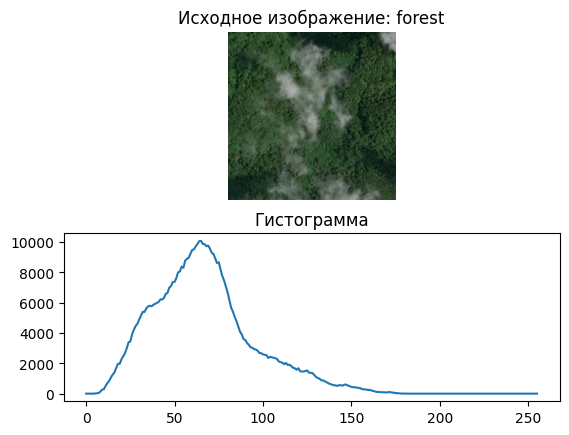

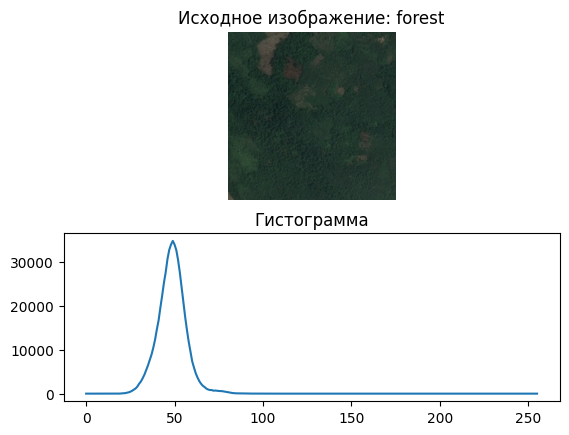

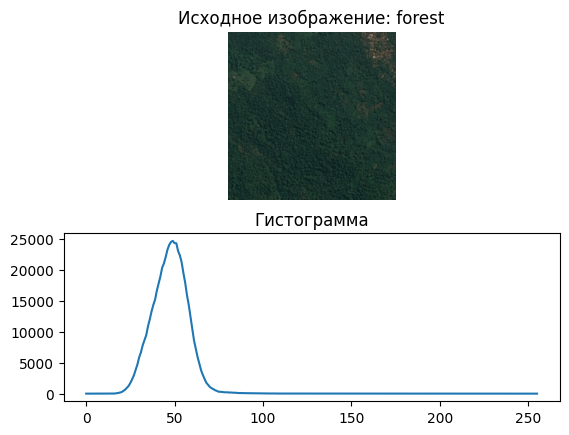

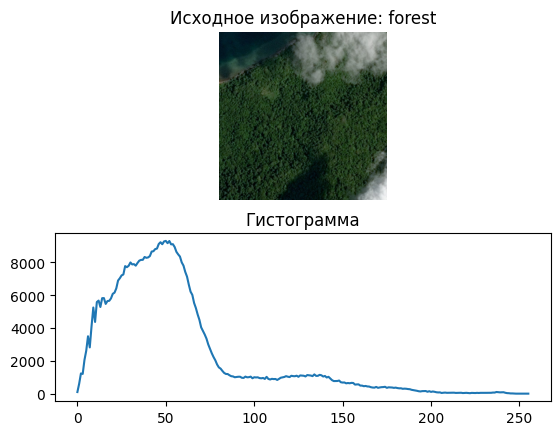

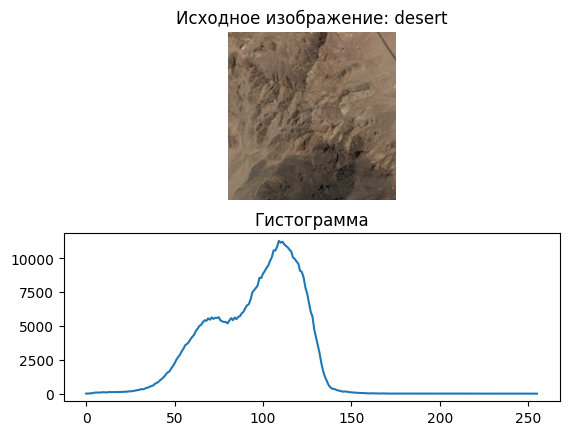

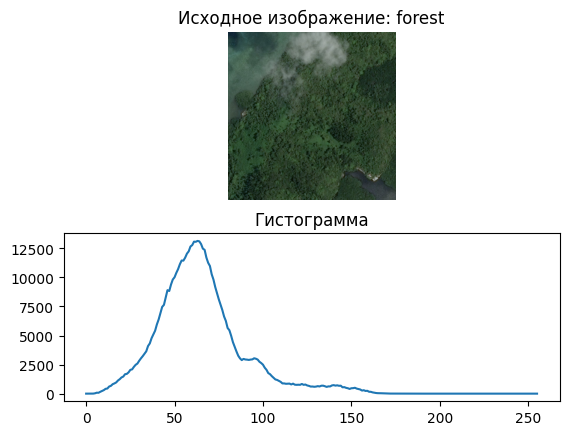

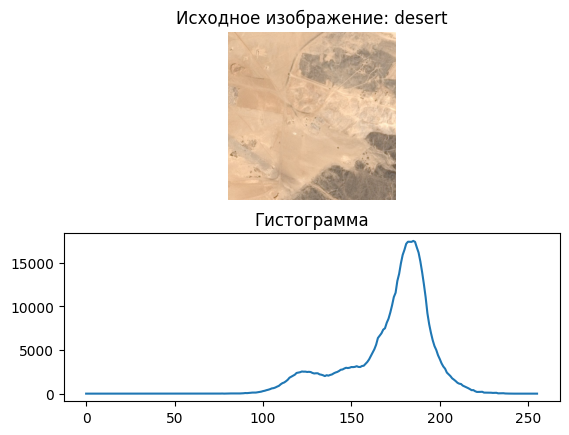

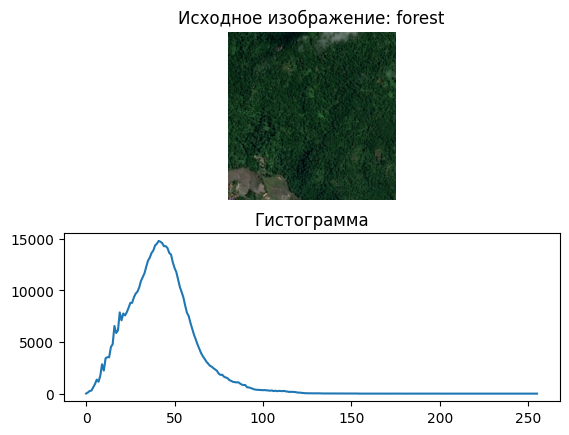

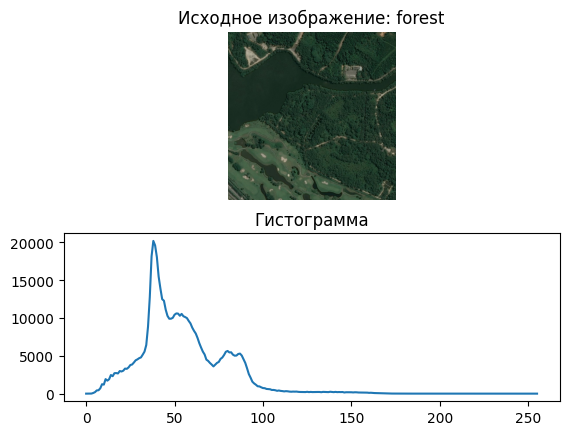

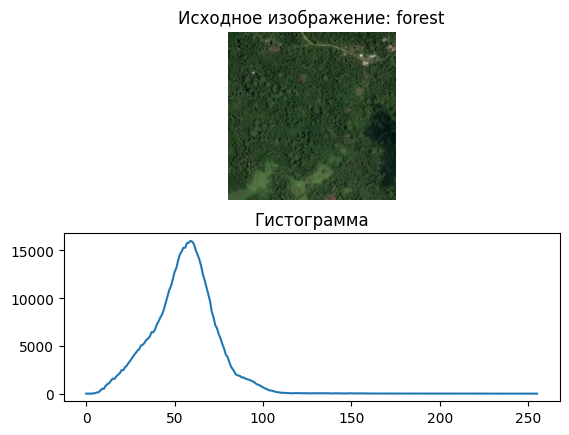

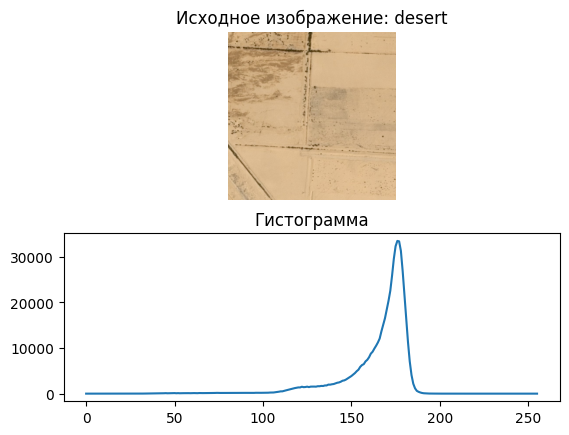

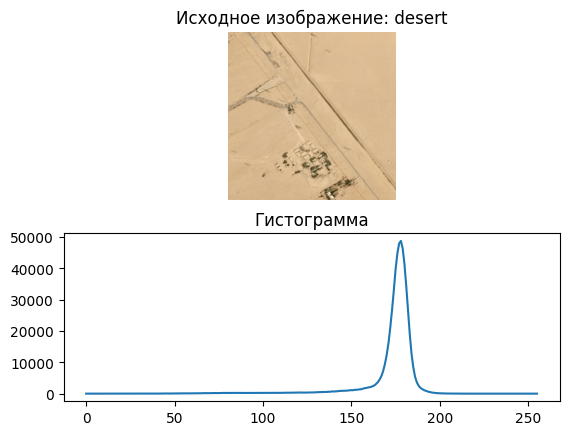

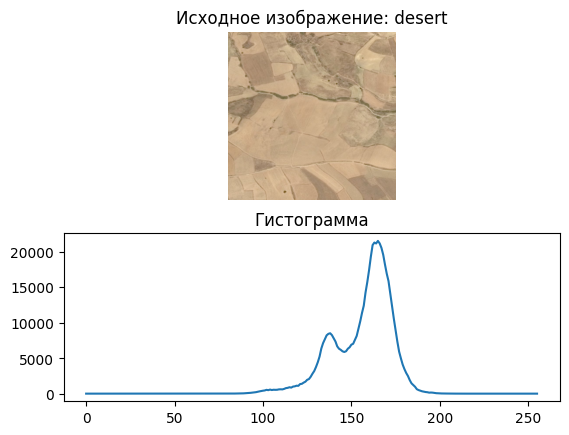

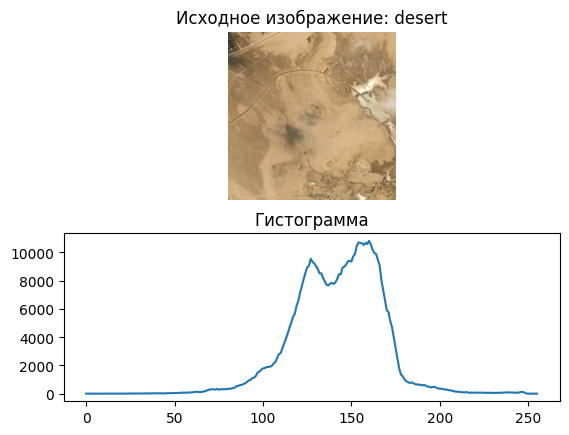

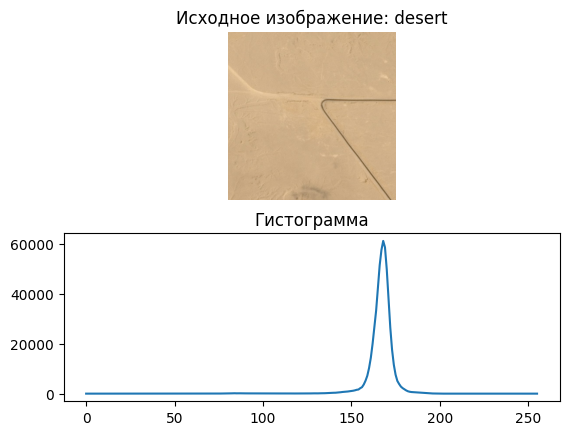

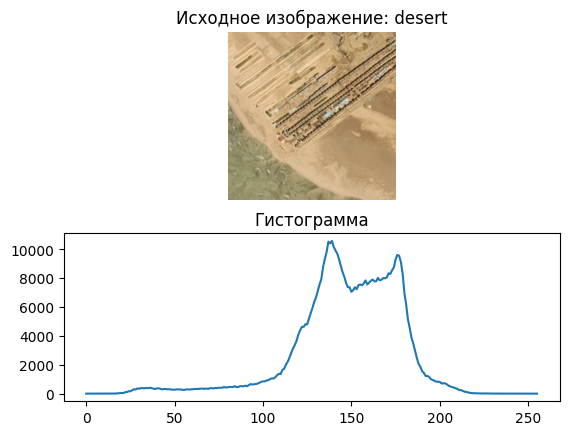

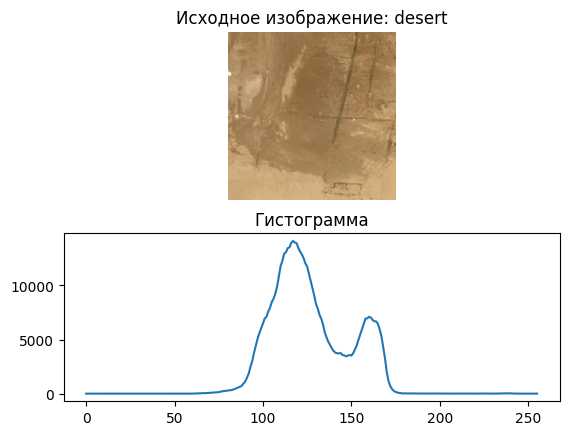

In [56]:
filenames = os.listdir("desert_forest/")

for name in filenames:
    desert_or_forest(f"desert_forest\\{name}")

# Задача №2 - Реализовать Image-blending на основе сшивки по градиентам

Задача - взять фото двух лиц : ваше и друга, с помощью метода Poisson image editing совместить глаза, нос и рот с первого изображения со вторым. Суть в том, что при использовании такого метода границы совмещенного изображения не видны.

Статья, где описан метод  

Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. https://doi.org/10.1145/882262.882269

Пример такого совмещения:

<img src="./blending/blending.png" alt="Drawing" style="width: 700px;"/>


In [108]:
def image_blending(image, details):
    # Проверяем размеры и типы изображения
    if details.shape[:2] != image.shape[:2]:
        raise ValueError("Размеры изображения и деталей должны совпадать.")

    # Выполняем бесшовное объединение с использованием Poisson Image Editing
    x, y = image.shape[1] // 2, image.shape[0] // 2 + 150  # Центр изображения
    result_image = cv2.seamlessClone(details, image, details[:, :, 3], (x, y), cv2.MONOCHROME_TRANSFER)

    # Отображение результата
    img = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)  # Преобразуем изображение из OpenCV в формат RGB
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Убираем оси
    plt.show()

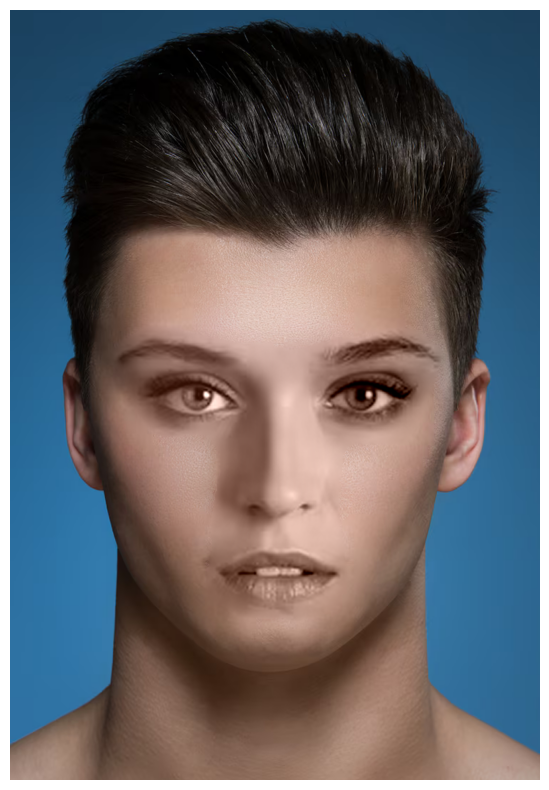

In [109]:
details = cv2.imread("blending\\details.png", cv2.IMREAD_UNCHANGED)
image = cv2.imread("blending\\man_image.png")

image_blending(image, details)

# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

In [46]:
def extract_cells(image, cell_size, num_cells):
    plt.figure(figsize=(8, 8))
    """
    Выделяет ячейки с клетками из большого изображения и отмечает их на изображении.

    :param image: Исходное изображение (numpy array, результат cv2.imread).
    :param cell_size: Размер ячейки (ширина, высота).
    :param num_cells: Количество ячеек для извлечения.
    :return: Список извлеченных ячеек (numpy array).
    """
    cell_width, cell_height = cell_size
    
    # Список для хранения извлеченных ячеек
    extracted_cells = []

    # Создаем копию изображения для отображения результатов
    annotated_image = image.copy()

    # Размеры исходного изображения
    img_height, img_width, _ = image.shape

    used_cells = set()  # Множество для отслеживания использованных областей

    for y in range(0, img_height, cell_height):
        for x in range(0, img_width, cell_width):
            # Выделяем ячейку из изображения
            cell = image[y:y + cell_height, x:x + cell_width]
            
            # Анализ ячейки для определения полезности (например, проверка непустого содержимого)
            if is_cell_relevant(cell):
                extracted_cells.append(cell)
                # Рисуем прямоугольник вокруг выбранной ячейки
                cv2.rectangle(annotated_image, (x, y), (x + cell_width, y + cell_height), (0, 255, 0), 2)

            # Останавливаемся, если набрали нужное количество ячеек
            if len(extracted_cells) >= num_cells:
                # Отображаем итоговое изображение с аннотациями
                plt.imshow(annotated_image)
                return extracted_cells

    # Отображаем итоговое изображение с аннотациями, если завершили полный цикл
    plt.imshow(annotated_image)
    return extracted_cells

def is_cell_relevant(cell_array, threshold=2000):
    """
    Проверяет, содержит ли ячейка достаточно информации, чтобы быть полезной.

    :param cell_array: Массив ячейки (numpy array).
    :param threshold: Порог для определения полезности (количество непустых пикселей).
    :return: True, если ячейка релевантна, иначе False.
    """
    # Подсчитываем количество пикселей, которые не равны фону (предполагаем фон белым: [255, 255, 255])
    non_empty_pixels = np.sum(np.any(cell_array < 200, axis=-1))
    return non_empty_pixels > threshold


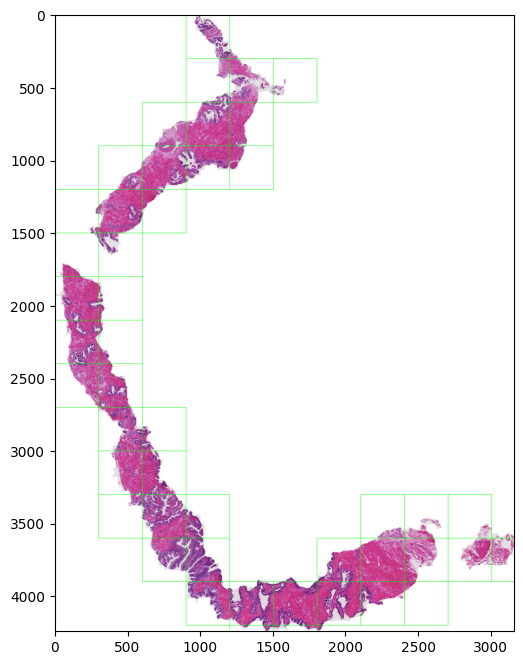

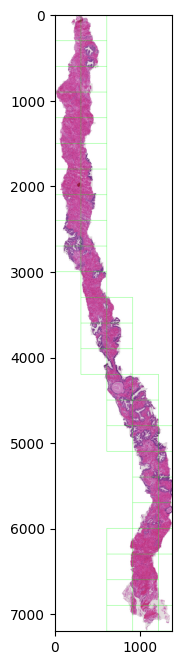

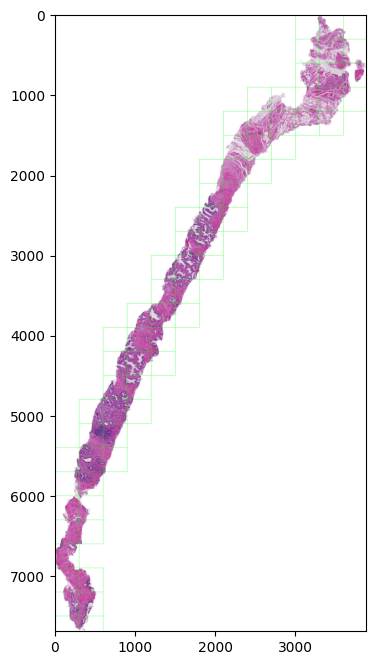

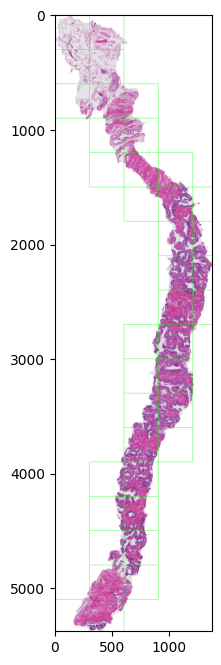

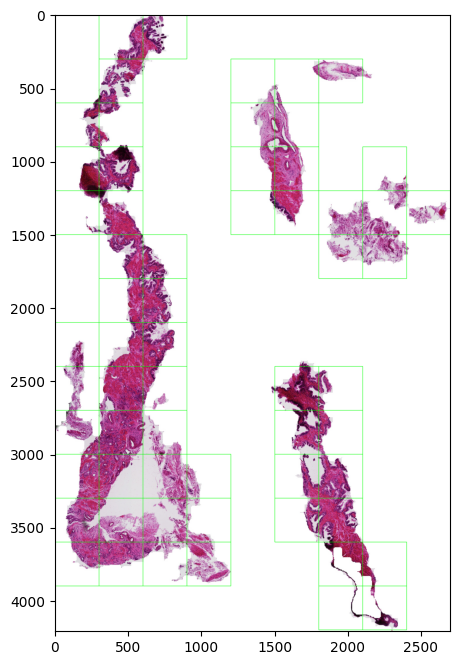

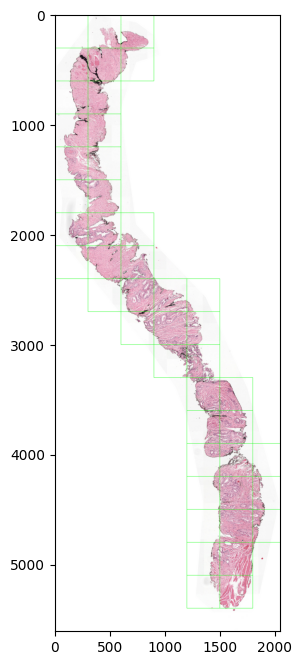

In [60]:
filenames = os.listdir("cells/")

for name in filenames:
    image = cv2.imread(f"cells\\{name}")
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    
    res = extract_cells(image, [300, 300], 100)

# plt.figure()
# plt.imshow(image)
# plt.show()

